In [1]:
# Read from a COMSOL-style data string or file and write to CSV-style format with comma separation

input_file = "/Users/leonardodelgaudio/Documents/14_Master/Msc_SS25/CQM_Msc_SS2025/TP_HW3/comsol_plit.txt"   # Replace with your actual filename
output_file = "/Users/leonardodelgaudio/Documents/14_Master/Msc_SS25/CQM_Msc_SS2025/TP_HW3/data_comma_separated.txt"

with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    for line in infile:
        stripped = line.strip()
        if stripped.startswith("%") or not stripped:
            continue  # Skip comments and empty lines
        parts = stripped.split()
        if len(parts) == 2:
            z, T = parts
            outfile.write(f"{z},{T}\n")


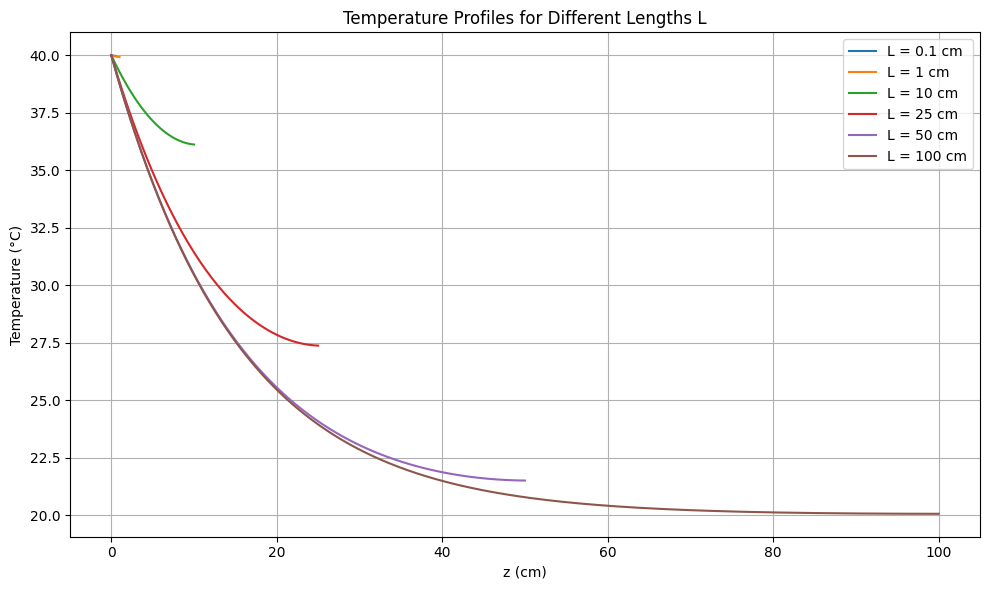

In [4]:
import matplotlib.pyplot as plt

# File containing the raw data
input_file = "data_comma_separated.txt"

# List of lengths in cm corresponding to each block (must match the order of data blocks)
L_values_cm = [0.1, 1, 10, 25, 50, 100]

# Initialize list to hold data blocks
all_profiles = []

with open(input_file, "r") as file:
    current_z = []
    current_T = []

    for line in file:
        stripped = line.strip()
        if stripped.startswith('%') or not stripped:
            continue  # skip comments and empty lines

        parts = stripped.split(",")
        if len(parts) != 2:
            continue

        z_str, T_str = parts
        z = float(z_str) * 100  # convert from meters to cm
        T = float(T_str)

        # A new block starts when we hit 0,40 again
        if z == 0 and T == 40 and current_z:
            all_profiles.append((current_z, current_T))
            current_z = []
            current_T = []

        current_z.append(z)
        current_T.append(T)

    # Add the final block
    if current_z:
        all_profiles.append((current_z, current_T))

# Plot all curves
plt.figure(figsize=(10, 6))
for (z_vals, T_vals), L in zip(all_profiles, L_values_cm):
    plt.plot(z_vals, T_vals, label=f"L = {L} cm")

plt.title("Temperature Profiles for Different Lengths L")
plt.xlabel("z (cm)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Analytical Temperature Profile: 21.173047440722144


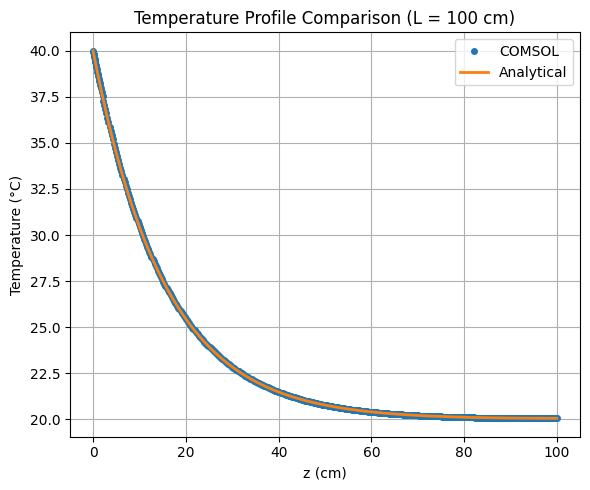

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# === Parameters for analytical solution ===
T0 = 40        # Initial temperature (°C)
T_inf = 20     # Ambient temperature (°C)
h = 50         # Heat transfer coefficient (W/m²K)
k = 237        # Thermal conductivity (W/mK)
W_cm = 1       # Width in cm
L_cm = 100     # Length in cm

# Analytical function
def r(x, T0, T_inf, h, k, W_cm, L_cm):
    W = W_cm / 100  # Convert width to meters
    L = L_cm / 100  # Convert length to meters
    k_val = np.sqrt(2 * h / (k * W))
    return T_inf + (T0 - T_inf) * (np.cosh(k_val * x / 100) - np.tanh(k_val * L) * np.sinh(k_val * x / 100))

# === Load COMSOL data ===
input_file = "data_comma_separated.txt"
all_profiles = []

with open(input_file, "r") as file:
    current_z = []
    current_T = []

    for line in file:
        stripped = line.strip()
        if stripped.startswith('%') or not stripped:
            continue

        parts = stripped.split(",")
        if len(parts) != 2:
            continue

        z_str, T_str = parts
        z = float(z_str) * 100  # convert from meters to cm
        T = float(T_str)

        if z == 0 and T == 40 and current_z:
            all_profiles.append((current_z, current_T))
            current_z = []
            current_T = []

        current_z.append(z)
        current_T.append(T)

    if current_z:
        all_profiles.append((current_z, current_T))

# Get the last profile (assumed L = 100 cm)
z_comsol, T_comsol = all_profiles[-1]

# === Generate analytical data ===
x_vals = np.array(z_comsol)
T_analytical = r(x_vals, T0, T_inf, h, k, W_cm, L_cm)
print("Analytical Temperature Profile:", T_analytical[200])

# === Plotting ===
plt.figure(figsize=(6, 5))
plt.plot(x_vals, T_comsol, 'o', label='COMSOL', markersize=4)
plt.plot(x_vals, T_analytical, '-', label='Analytical', linewidth=2)

plt.title("Temperature Profile Comparison (L = 100 cm)")
plt.xlabel("z (cm)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The linear approximation is closest to 20 at z = 15.38 cm with T = 20.07 °C


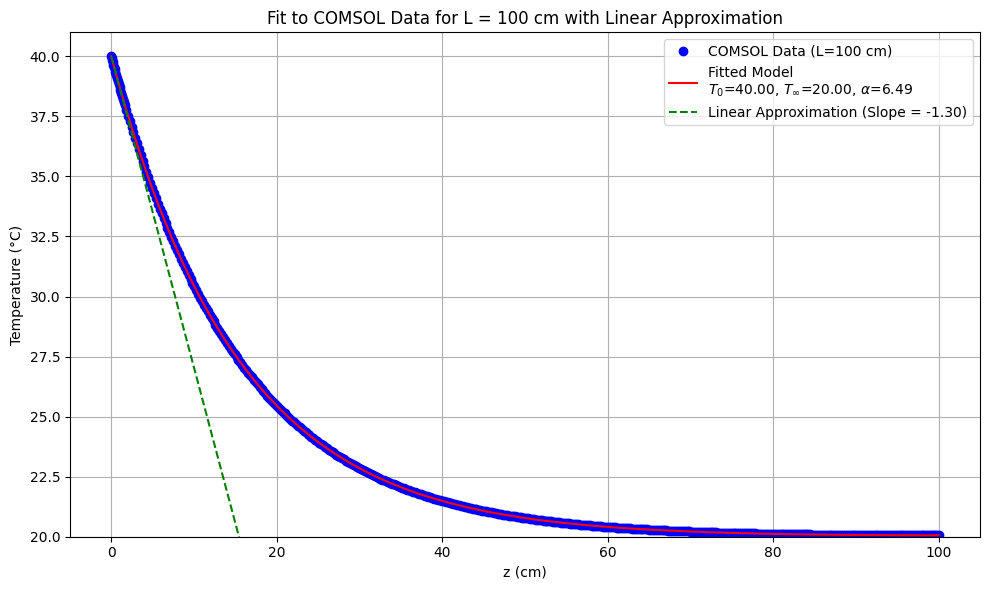

(np.float64(40.00276979209816),
 np.float64(19.999315126689144),
 np.float64(6.493738382023027),
 np.float64(-1.2961582926449777))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the data for L = 100 cm from previous parsing
data = np.loadtxt("data_comma_separated.txt", comments='%', delimiter=',')
z_vals = data[:, 0] * 100  # Convert m to cm
T_vals = data[:, 1]

# Extract only the L=100 block (assumed to be the last one based on previous code)
block_indices = np.where((z_vals == 0) & (T_vals == 40))[0]
if len(block_indices) > 1:
    start_index = block_indices[-1]
else:
    start_index = 0
z_L100 = z_vals[start_index:]
T_L100 = T_vals[start_index:]

# Analytical function with better fitting strategy (allow T0 as variable too)
def model_func(x, T0, T_inf, alpha):
    x_m = x / 100  # convert cm to m
    L_m = 1.0  # L = 100 cm = 1 m
    return T_inf + (T0 - T_inf) * (np.cosh(alpha * x_m) - np.tanh(alpha * L_m) * np.sinh(alpha * x_m))

# Initial guesses for T0, T_inf, and alpha
initial_guess = [40, 20, 1.0]

# Fit the model
popt, _ = curve_fit(model_func, z_L100, T_L100, p0=initial_guess)
T0_fit, Tinf_fit, alpha_fit = popt

# Compute fitted values
T_fit = model_func(z_L100, *popt)

# Calculate the slope from the first two fitted points
z_first, T_first = z_L100[0], T_fit[0]
z_second, T_second = z_L100[1], T_fit[1]

# Calculate slope: (T_second - T_first) / (z_second - z_first)
slope_m = (T_second - T_first) / (z_second - z_first)

# Define the linear approximation using the calculated slope
def linear_approx(x, slope_m, T_first):
    return T_first + slope_m * (x - z_first)

# Compute linear approximation values
T_linear_approx = linear_approx(z_L100, slope_m, T_first)
# Find the value of the linear approximation closest to 20
closest_index = np.argmin(np.abs(T_linear_approx - 20))
closest_z = z_L100[closest_index]
closest_T = T_linear_approx[closest_index]

print(f"The linear approximation is closest to 20 at z = {closest_z:.2f} cm with T = {closest_T:.2f} °C")

# Plot original vs fit
plt.figure(figsize=(10, 6))
plt.plot(z_L100, T_L100, 'bo', label="COMSOL Data (L=100 cm)")
plt.plot(z_L100, T_fit, 'r-', label=f"Fitted Model\n$T_0$={T0_fit:.2f}, $T_\\infty$={Tinf_fit:.2f}, $\\alpha$={alpha_fit:.2f}")
plt.plot(z_L100, T_linear_approx, color='g', linestyle='--', label=f"Linear Approximation (Slope = {slope_m:.2f})")
plt.xlabel("z (cm)")
plt.ylabel("Temperature (°C)")
plt.title("Fit to COMSOL Data for L = 100 cm with Linear Approximation")
plt.ylim(20, 41)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Return fitted parameters and slope
T0_fit, Tinf_fit, alpha_fit, slope_m


The linear approximation is closest to 20 at z = 15.38 cm with T = 20.07 °C


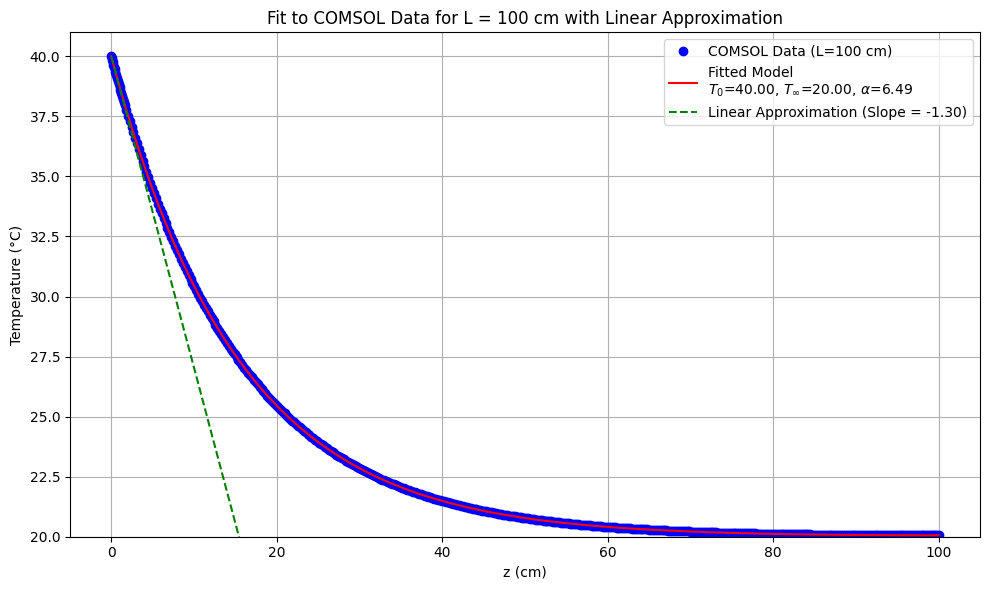

(np.float64(40.00276979209816),
 np.float64(19.999315126689144),
 np.float64(6.493738382023027),
 np.float64(-1.2961582926449777))

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the data for L = 100 cm from previous parsing
data = np.loadtxt("data_comma_separated.txt", comments='%', delimiter=',')
z_vals = data[:, 0] * 100  # Convert m to cm
T_vals = data[:, 1]

# Extract only the L=100 block (assumed to be the last one based on previous code)
block_indices = np.where((z_vals == 0) & (T_vals == 40))[0]
if len(block_indices) > 1:
    start_index = block_indices[-1]
else:
    start_index = 0
z_L100 = z_vals[start_index:]
T_L100 = T_vals[start_index:]

# Analytical function with better fitting strategy (allow T0 as variable too)
def model_func(x, T0, T_inf, alpha):
    x_m = x / 100  # convert cm to m
    L_m = 1.0  # L = 100 cm = 1 m
    return T_inf + (T0 - T_inf) * (np.cosh(alpha * x_m) - np.tanh(alpha * L_m) * np.sinh(alpha * x_m))

# Initial guesses for T0, T_inf, and alpha
initial_guess = [40, 20, 1.0]

# Fit the model
popt, _ = curve_fit(model_func, z_L100, T_L100, p0=initial_guess)
T0_fit, Tinf_fit, alpha_fit = popt

# Compute fitted values
T_fit = model_func(z_L100, *popt)

# Calculate the slope from the first two fitted points
z_first, T_first = z_L100[0], T_fit[0]
z_second, T_second = z_L100[1], T_fit[1]

# Calculate slope: (T_second - T_first) / (z_second - z_first)
slope_m = (T_second - T_first) / (z_second - z_first)

# Define the linear approximation using the calculated slope
def linear_approx(x, slope_m, T_first):
    return T_first + slope_m * (x - z_first)

# Compute linear approximation values
T_linear_approx = linear_approx(z_L100, slope_m, T_first)
# Find the value of the linear approximation closest to 20
closest_index = np.argmin(np.abs(T_linear_approx - 20))
closest_z = z_L100[closest_index]
closest_T = T_linear_approx[closest_index]

print(f"The linear approximation is closest to 20 at z = {closest_z:.2f} cm with T = {closest_T:.2f} °C")

# Plot original vs fit
plt.figure(figsize=(10, 6))
plt.plot(z_L100, T_L100, 'bo', label="COMSOL Data (L=100 cm)")
plt.plot(z_L100, T_fit, 'r-', label=f"Fitted Model\n$T_0$={T0_fit:.2f}, $T_\\infty$={Tinf_fit:.2f}, $\\alpha$={alpha_fit:.2f}")
plt.plot(z_L100, T_linear_approx, color='g', linestyle='--', label=f"Linear Approximation (Slope = {slope_m:.2f})")
plt.xlabel("z (cm)")
plt.ylabel("Temperature (°C)")
plt.title("Fit to COMSOL Data for L = 100 cm with Linear Approximation")
plt.ylim(20, 41)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Return fitted parameters and slope
T0_fit, Tinf_fit, alpha_fit, slope_m


The linear approximation is closest to 20 at z = 15.38 cm with T = 20.07 °C


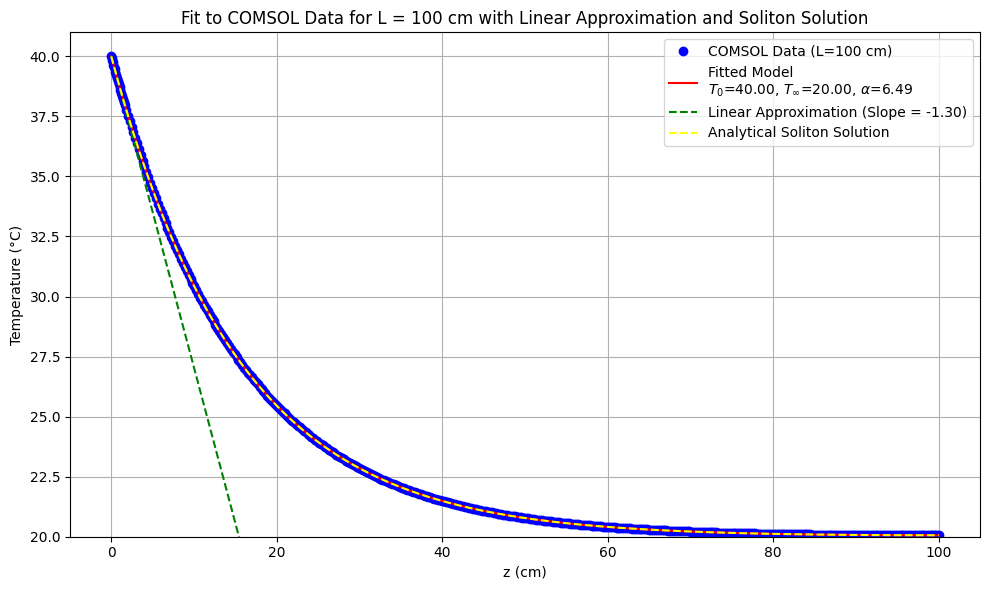

(np.float64(40.00276979209816),
 np.float64(19.999315126689144),
 np.float64(6.493738382023027),
 np.float64(-1.2961582926449777))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the data for L = 100 cm from previous parsing
data = np.loadtxt("data_comma_separated.txt", comments='%', delimiter=',')
z_vals = data[:, 0] * 100  # Convert m to cm
T_vals = data[:, 1]

# Extract only the L=100 block (assumed to be the last one based on previous code)
block_indices = np.where((z_vals == 0) & (T_vals == 40))[0]
if len(block_indices) > 1:
    start_index = block_indices[-1]
else:
    start_index = 0
z_L100 = z_vals[start_index:]
T_L100 = T_vals[start_index:]

# Analytical soliton temperature profile
def T_bar(z, T0, T_inf, h, k_material, W, L):
    # Convert W and L from cm to m for consistency in SI units
    W_m = W / 100
    L_m = L / 100
    z_m = z / 100
    
    k = np.sqrt(2 * h / (k_material * W_m))
    return T_inf + (T0 - T_inf) * (np.cosh(k * z_m) - np.tanh(k * L_m) * np.sinh(k * z_m))

def dT_bar_dz_at_0(T0, T_inf, h, k_material, W, L):
    # Convert W and L from cm to m
    W_m = W / 100
    L_m = L / 100

    # Compute k
    k = np.sqrt(2 * h / (k_material * W_m))

    # Derivative at z = 0
    return -k * (T0 - T_inf) * np.tanh(k * L_m)

# Analytical soliton parameters
T0 = 40
T_inf = 20
h = 50         # W/(m2.K)
k_material = 237  # W/(m.K)
W = 1          # cm
L = 100        # cm

# Compute the analytical soliton temperature profile for plotting
z_points = np.linspace(min(z_L100), max(z_L100), 5000)
T_soliton = T_bar(z_points, T0, T_inf, h, k_material, W, L)

# Fit the model for experimental data (as before)
def model_func(x, T0, T_inf, alpha):
    x_m = x / 100  # convert cm to m
    L_m = 1.0  # L = 100 cm = 1 m
    return T_inf + (T0 - T_inf) * (np.cosh(alpha * x_m) - np.tanh(alpha * L_m) * np.sinh(alpha * x_m))

# Initial guesses for T0, T_inf, and alpha
initial_guess = [40, 20, 1.0]

# Fit the model
popt, _ = curve_fit(model_func, z_L100, T_L100, p0=initial_guess)
T0_fit, Tinf_fit, alpha_fit = popt

# Compute fitted values
T_fit = model_func(z_L100, *popt)

# Calculate the slope from the first two fitted points
z_first, T_first = z_L100[0], T_fit[0]
z_second, T_second = z_L100[1], T_fit[1]

# Calculate slope: (T_second - T_first) / (z_second - z_first)
slope_m = (T_second - T_first) / (z_second - z_first)

# Define the linear approximation using the calculated slope
def linear_approx(x, slope_m, T_first):
    return T_first + slope_m * (x - z_first)

# Compute linear approximation values
T_linear_approx = linear_approx(z_L100, slope_m, T_first)
# Find the value of the linear approximation closest to 20
closest_index = np.argmin(np.abs(T_linear_approx - 20))
closest_z = z_L100[closest_index]
closest_T = T_linear_approx[closest_index]

print(f"The linear approximation is closest to 20 at z = {closest_z:.2f} cm with T = {closest_T:.2f} °C")

# Plot original vs fit, including the soliton
plt.figure(figsize=(10, 6))
plt.plot(z_L100, T_L100, 'bo', label="COMSOL Data (L=100 cm)")
plt.plot(z_L100, T_fit, 'r-', label=f"Fitted Model\n$T_0$={T0_fit:.2f}, $T_\\infty$={Tinf_fit:.2f}, $\\alpha$={alpha_fit:.2f}")
plt.plot(z_L100, T_linear_approx, color='g', linestyle='--', label=f"Linear Approximation (Slope = {slope_m:.2f})")
plt.plot(z_points, T_soliton, color='yellow', linestyle='--', label="Analytical Soliton Solution")
plt.xlabel("z (cm)")
plt.ylabel("Temperature (°C)")
plt.title("Fit to COMSOL Data for L = 100 cm with Linear Approximation and Soliton Solution")
plt.ylim(20, 41)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Return fitted parameters and slope
T0_fit, Tinf_fit, alpha_fit, slope_m
